## 模型构建与训练

In [1]:
import pandas as pd
import numpy as np
import psutil
import os
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout


/home/myth/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 定义网络结构

In [15]:

class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=6,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

### 数据处理与训练

In [3]:
info = psutil.virtual_memory()
print (u'内存使用：',psutil.Process(os.getpid()).memory_info().rss)
print (u'剩余内存：',info.total-psutil.Process(os.getpid()).memory_info().rss)

内存使用： 324444160
剩余内存： 7943114752


In [4]:
train = pd.read_csv('train.csv',index_col=0)
train.head()

,ID,Age,Gender,Education,Query_List1
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,"['柔和', '双沟', '女生', '中财网', '首页', ' ', '财经', 'pa..."
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,"['广州', '厨宝', '烤箱', '世情', '薄', ',', '人情', '恶', ..."
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,"['钻石', '之泪', '耳机', '盘锦', '到', '沈阳', '旅顺', '公交'..."
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,"['最', '受欢迎', '狗狗', '排行榜', '舶', '怎么', '读', '场景'..."
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,"['干槽症', '能', '自愈', '吗', '太太', '万岁', '叶', '舒心',..."


In [5]:
train.Query_List1 = train.Query_List1.apply(eval)

In [8]:
# 路径等配置
data_dir = "./processed_data"
vocab_file = "./vocab/vocab.txt"
vocab_size = 40000
#构造词表
from tkinter import _flatten
words = train['Query_List1'].values.tolist()

In [9]:
words = set(_flatten(words))

In [8]:
def save_data(path,sentences):
    # 将数据保存到txt中
    print("writing data to fasttext format...")
    out = open(path, 'w', encoding='utf-8')
    for sentence in sentences:
        out.write(sentence+"\n")
    print("done!")

In [26]:
save_data(vocab_file,words)

writing data to fasttext format...
done!


In [19]:
def build_vocab(data_train, vocab_file, vocab_size=5000):
    """根据训练集构建词汇表，存储"""
#     data_train, _ = read_files(train_dir)
    all_data = []
    for content in data_train:
        all_data.extend(content)

    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open_file(vocab_file, mode='w').write('\n'.join(words) + '\n')

In [20]:
build_vocab(train.Query_List1.values.tolist(),vocab_file, vocab_size)

In [21]:
# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 64
embedding_dims = 50
epochs = 8

print('数据预处理与加载数据...')
# 如果不存在词汇表，重建
# if not os.path.exists(vocab_file):  
#     build_vocab(data_dir, vocab_file, vocab_size)
# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category_a()
words, word_to_id = read_vocab(vocab_file)


# 切分训练集和测试集
# 转化年龄数据
train_set, test_set = train_test_split(train[train['Age']>0],\
                                       stratify=train[train['Age']>0].Age,\
                                       random_state=42)
# 对文本的词id和类别id进行编码
x_train = encode_sentences(train_set['Query_List1'].values.tolist(), word_to_id)
y_train = to_categorical(encode_cate(train_set['Age'].values.tolist(), cat_to_id))
x_test = encode_sentences(test_set['Query_List1'].values.tolist(), word_to_id)
y_test = to_categorical(encode_cate(test_set['Age'].values.tolist(), cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)





#print('对测试集预测...')
#result = model.predict(x_test)

数据预处理与加载数据...
对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73750, 100)
x_test shape: (24584, 100)


In [15]:
cat_to_id

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [22]:
# fit拟合数据
# max_features = 600001
print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model_a.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

构建模型...
训练...
Train on 73750 samples, validate on 24584 samples
Epoch 1/8
73728/73750 [============================>.] - ETA: 0s - loss: 1.2156 - accuracy: 0.5039
Epoch 00001: saving model to ./cnn_model_a.h5
73750/73750 [==============================] - 219s 3ms/sample - loss: 1.2156 - accuracy: 0.5039 - val_loss: 1.1542 - val_accuracy: 0.5344
Epoch 2/8
73728/73750 [============================>.] - ETA: 0s - loss: 1.0003 - accuracy: 0.6178
Epoch 00002: saving model to ./cnn_model_a.h5
73750/73750 [==============================] - 235s 3ms/sample - loss: 1.0003 - accuracy: 0.6178 - val_loss: 1.1790 - val_accuracy: 0.5296
Epoch 3/8
73728/73750 [============================>.] - ETA: 0s - loss: 0.7182 - accuracy: 0.7469
Epoch 00003: saving model to ./cnn_model_a.h5
73750/73750 [==============================] - 245s 3ms/sample - loss: 0.7182 - accuracy: 0.7469 - val_loss: 1.3552 - val_accuracy: 0.5111


In [ ]:
model_a = model

### 训练中间信息输出

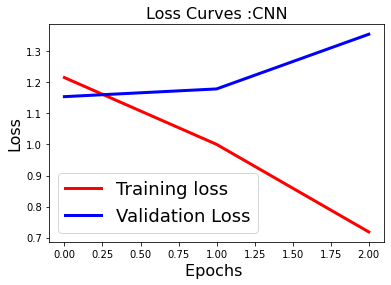

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

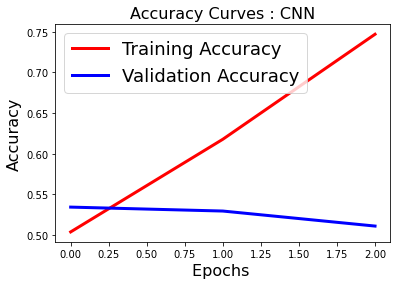

In [27]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [31]:
from tensorflow.keras.utils import plot_model
import pydot,graphviz

In [32]:
pydot 

<module 'pydot' from '/home/myth/anaconda3/lib/python3.6/site-packages/pydot.py'>

In [33]:
graphviz

<module 'graphviz' from '/home/myth/anaconda3/lib/python3.6/site-packages/graphviz/__init__.py'>

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### 性别

In [35]:
# 切分训练集和测试集
# 转化年龄数据
categories, cat_to_id = read_category_g()
train_set, test_set = train_test_split(train[train['Gender']>0],\
                                       stratify=train[train['Gender']>0].Gender,\
                                       random_state=42)
# 对文本的词id和类别id进行编码
x_train = encode_sentences(train_set['Query_List1'].values.tolist(), word_to_id)
y_train = to_categorical(encode_cate(train_set['Gender'].values.tolist(), cat_to_id))
x_test = encode_sentences(test_set['Query_List1'].values.tolist(), word_to_id)
y_test = to_categorical(encode_cate(test_set['Gender'].values.tolist(), cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# fit拟合数据
# max_features = 40001
print('构建模型...')
model_g = TextCNN(maxlen, max_features, embedding_dims,class_num=2).get_model()
model_g.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model_g.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]
history = model_g.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73383, 100)
x_test shape: (24462, 100)
构建模型...
训练...
Train on 73383 samples, validate on 24462 samples
Epoch 1/8
73344/73383 [============================>.] - ETA: 0s - loss: 0.5095 - accuracy: 0.7639
Epoch 00001: saving model to ./cnn_model_g.h5
73383/73383 [==============================] - 254s 3ms/sample - loss: 0.5095 - accuracy: 0.7639 - val_loss: 0.4941 - val_accuracy: 0.7763
Epoch 2/8
73344/73383 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8443
Epoch 00002: saving model to ./cnn_model_g.h5
73383/73383 [==============================] - 247s 3ms/sample - loss: 0.3844 - accuracy: 0.8444 - val_loss: 0.5127 - val_accuracy: 0.7778
Epoch 3/8
73344/73383 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9203
Epoch 00003: saving model to ./cnn_model_g.h5
73383/73383 [==============================] - 230s 3ms/sample - loss: 0.2186 - accuracy: 0.9203 - val_loss: 0.6174 - val_accuracy:

### 训练中间信息输出

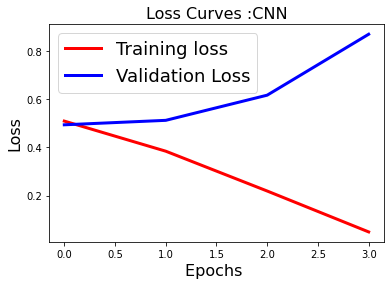

In [36]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

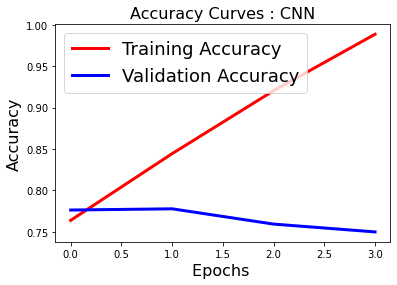

In [37]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### 学历

In [38]:
# 切分训练集和测试集
# 转化学历数据
categories, cat_to_id = read_category_e()
train_set, test_set = train_test_split(train[train['Education']>0],\
                                       stratify=train[train['Education']>0].Education,\
                                       random_state=42)
# 对文本的词id和类别id进行编码
x_train = encode_sentences(train_set['Query_List1'].values.tolist(), word_to_id)
y_train = to_categorical(encode_cate(train_set['Education'].values.tolist(), cat_to_id))
x_test = encode_sentences(test_set['Query_List1'].values.tolist(), word_to_id)
y_test = to_categorical(encode_cate(test_set['Education'].values.tolist(), cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
# fit拟合数据
# max_features = 40001
print('构建模型...')
model_e = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
model_e.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model_e.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]
history = model_e.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (68040, 100)
x_test shape: (22680, 100)
构建模型...
训练...
Train on 68040 samples, validate on 22680 samples
Epoch 1/8
68032/68040 [============================>.] - ETA: 0s - loss: 1.1235 - accuracy: 0.5247
Epoch 00001: saving model to ./cnn_model_e.h5
68040/68040 [==============================] - 186s 3ms/sample - loss: 1.1236 - accuracy: 0.5247 - val_loss: 1.0518 - val_accuracy: 0.5646
Epoch 2/8
68032/68040 [============================>.] - ETA: 0s - loss: 0.9092 - accuracy: 0.6471
Epoch 00002: saving model to ./cnn_model_e.h5
68040/68040 [==============================] - 182s 3ms/sample - loss: 0.9092 - accuracy: 0.6471 - val_loss: 1.0864 - val_accuracy: 0.5552
Epoch 3/8
68032/68040 [============================>.] - ETA: 0s - loss: 0.6109 - accuracy: 0.7866
Epoch 00003: saving model to ./cnn_model_e.h5
68040/68040 [==============================] - 182s 3ms/sample - loss: 0.6109 - accuracy: 0.7866 - val_loss: 1.2574 - val_accuracy:

### 训练中间信息输出

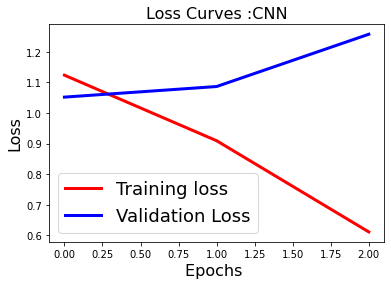

In [39]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

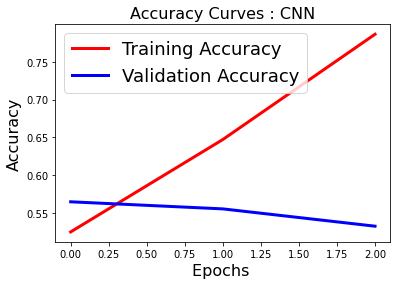

In [40]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [19]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(73750, 100) (73750, 6)
(24584, 100) (24584, 6)


### 保存模型

In [46]:
# from joblib import dump,load
path = 'TextCNNModel.model'
model.save('model/tCNN_a.model')
model_g.save('model/tCNN_g.model')
model_e.save('model/tCNN_e.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/tCNN_a.model/assets
INFO:tensorflow:Assets written to: model/tCNN_g.model/assets
INFO:tensorflow:Assets written to: model/tCNN_e.model/assets
